In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
#import operator
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from itertools import combinations
from sklearn.metrics import roc_curve

In [2]:
# Load your data and preprocess it
X = np.load('Data/ds_colorferet_emb.npy', allow_pickle=True)
identities = np.load('data/ds_colorferet_identities.npy', allow_pickle=True)

## 1. Split the data into 70% training and 30% testing sets.

In [3]:
data =  list(zip(X, identities))

# Count the number of embeddings for each identity
identity_counts = {}
for _, identity in data:
    if identity in identity_counts:
        identity_counts[identity] += 1
    else:
        identity_counts[identity] = 1

# Define the target split ratio (e.g., 80% train, 20% test)
train_ratio = 0.7
test_ratio = 0.3

# Calculate the number of embeddings needed for train and test sets
total_embeddings = len(data)
train_size = int(total_embeddings * train_ratio)
test_size = int(total_embeddings * test_ratio)

# Initialize train and test sets
x_train = []
y_train = []
x_test = []
y_test = []

# Sort identities by the number of embeddings (in descending order)
sorted_identities = sorted(identity_counts.keys(), key=lambda identity: -identity_counts[identity])

# Initialize counts for train and test sets
train_count = 0
test_count = 0

# Iterate through sorted identities and allocate embeddings to train or test sets
for identity in sorted_identities:
    embeddings_for_identity = [(embedding, iden) for embedding, iden in data if iden == identity] #all embeddings of a specific identity

    # Determine the size of the gap for train and test sets
    train_gap = train_size - train_count
    test_gap = test_size - test_count

    # Calculate the number of embeddings to allocate for this identity
    num_embeddings_for_identity = len(embeddings_for_identity)

    if train_gap >= test_gap:
        # Allocate embeddings to train set
        num_to_allocate = min(train_gap, num_embeddings_for_identity)
        x_train.extend([embedding for embedding, _ in embeddings_for_identity[:num_to_allocate]])
        y_train.extend([_ for embedding, _ in embeddings_for_identity[:num_to_allocate]])
        train_count += num_to_allocate
    else:
        # Allocate embeddings to test set
        num_to_allocate = min(test_gap, num_embeddings_for_identity)
        x_test.extend([embedding for embedding, _ in embeddings_for_identity[:num_to_allocate]])
        y_test.extend([_ for embedding, _ in embeddings_for_identity[:num_to_allocate]])
        test_count += num_to_allocate

# Shuffle the train and test sets to ensure randomness
train_data = list(zip(x_train, y_train))
test_data = list(zip(x_test, y_test))
# np.random.shuffle(train_data)
# np.random.shuffle(test_data)

x_train, train_identities = zip(*train_data)
x_test, test_identities = zip(*test_data)

x_train = np.array(x_train)
train_identities = np.array(y_train)
x_test = np.array(x_test)
test_identities = np.array(y_test)

## 2. Compute the ROC curve on the test set

In [4]:
def createGenuineIDs(identities):
    """Create genuine ID_sets
    """
    genuine_ID_sets = []
    for i in set(identities):
        idx = np.argwhere(identities==i)
        genuine_ID_sets.append(idx)
    return genuine_ID_sets
    #in each list we have all positions referring to the same identity

def createImposterIDs(identities, num_imposter=10):
    np.random.seed(1)
    imposter_ID_sets = []
    for i in set(identities):
        idx = np.argwhere(identities!=i)
        np.random.shuffle(idx)
        idx_reduced = idx[:num_imposter]
        imposter_ID_sets.append(idx_reduced)
    return imposter_ID_sets
    #in each list we have 10 positions referring to different identities

def cos_sim(a,b):
    """ Cosine similarity between vector a and b
    """
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

def computeScores(ID_sets, X, sim_fct):
    scores = []
    for i in range(len(ID_sets)):
        combs = combinations(ID_sets[i], 2)
        for comb in combs:
            x_probe, x_ref = X[comb[0],:], X[comb[1],:]
            score = sim_fct(x_probe, x_ref)
            scores.append(score) 
    return np.array(scores)

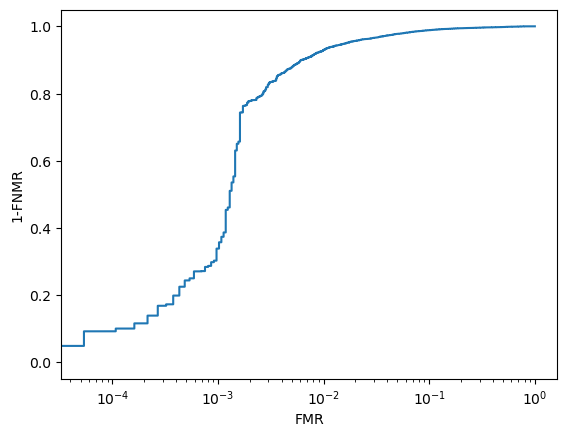

In [6]:
gen_pairs = createGenuineIDs(test_identities)
imp_pairs =  createImposterIDs(test_identities)
genuine_scores = computeScores(gen_pairs, x_test, cos_sim)
imposter_scores = computeScores(imp_pairs, x_test, cos_sim)

gen_id = np.ones(len(genuine_scores))
imp_id = np.zeros(len(imposter_scores))
# merged      
scores = np.hstack([genuine_scores, imposter_scores])
labels = np.hstack([gen_id, imp_id])

fpr, tpr, thresholds = roc_curve(labels, scores)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FMR")
plt.ylabel("1-FNMR")
plt.xscale("log")

plt.show()

## 3.	Implement a deep learning model to learn face embeddings of size 32
This can be done in two ways
1. Training a network to reconstrcut the embedding as output
2. Training a network to classify each embedding to the corresponding identity

Let's see both approaches

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_face_embedding_model(embedding_dim):
    """
    Create a neural network model for learning face embeddings.

    Args:
    - embedding_dim (int): The dimensionality of the face embeddings.

    Returns:
    - model (tensorflow.keras.Model): The constructed neural network model.
    - intermediate_layer (tensorflow.keras.layers.Layer): The intermediate layer that produces the reduced embeddings.
    """
    # Define the input layer for face embeddings
    input_layer = keras.Input(shape=(embedding_dim,), name="face_embeddings")

    # Define a hidden layer
    hidden_layer = layers.Dense(128, activation="relu")(input_layer)
    hidden_layer = layers.Dropout(0.5)(hidden_layer)

    # Define an intermediate layer with 32 units
    intermediate_layer = layers.Dense(32, activation="relu")(hidden_layer)

    # Define the output layer with no activation (identity prediction)
    output_layer = layers.Dense(embedding_dim)(intermediate_layer)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer, name="face_embedding_model")

    return model, intermediate_layer

# Specify the embedding dimension 
embedding_dim = 128


# Create the model and obtain the intermediate layer
model, intermediate_layer = create_face_embedding_model(embedding_dim)

# Compile the model with an appropriate loss and optimizer
model.compile(
    optimizer="adam",
    loss="mse",  # Use mean squared error as the loss
)

model.fit(x_train, x_train, epochs=100, batch_size=32, verbose=2)

# Now, you can train the model using your face embeddings as both input and target.
# This trains the model to produce embeddings that are similar to the input embeddings.

# After training, create a new model to extract the reduced embeddings
reduced_embeddings_model = keras.Model(inputs=model.input, outputs=intermediate_layer)

# You can use reduced_embeddings_model.predict(your_face_embeddings) to obtain the reduced embeddings.
reduced_embeddings = reduced_embeddings_model.predict(x_test)

Epoch 1/100
247/247 - 1s - loss: 0.0073 - 513ms/epoch - 2ms/step
Epoch 2/100
247/247 - 0s - loss: 0.0055 - 163ms/epoch - 661us/step
Epoch 3/100
247/247 - 0s - loss: 0.0045 - 157ms/epoch - 634us/step
Epoch 4/100
247/247 - 0s - loss: 0.0042 - 156ms/epoch - 632us/step
Epoch 5/100
247/247 - 0s - loss: 0.0040 - 148ms/epoch - 599us/step
Epoch 6/100
247/247 - 0s - loss: 0.0039 - 155ms/epoch - 629us/step
Epoch 7/100
247/247 - 0s - loss: 0.0039 - 147ms/epoch - 597us/step
Epoch 8/100
247/247 - 0s - loss: 0.0039 - 144ms/epoch - 583us/step
Epoch 9/100
247/247 - 0s - loss: 0.0038 - 155ms/epoch - 626us/step
Epoch 10/100
247/247 - 0s - loss: 0.0038 - 153ms/epoch - 617us/step
Epoch 11/100
247/247 - 0s - loss: 0.0038 - 149ms/epoch - 602us/step
Epoch 12/100
247/247 - 0s - loss: 0.0038 - 152ms/epoch - 616us/step
Epoch 13/100
247/247 - 0s - loss: 0.0038 - 148ms/epoch - 599us/step
Epoch 14/100
247/247 - 0s - loss: 0.0038 - 148ms/epoch - 600us/step
Epoch 15/100
247/247 - 0s - loss: 0.0038 - 152ms/epoch - 61

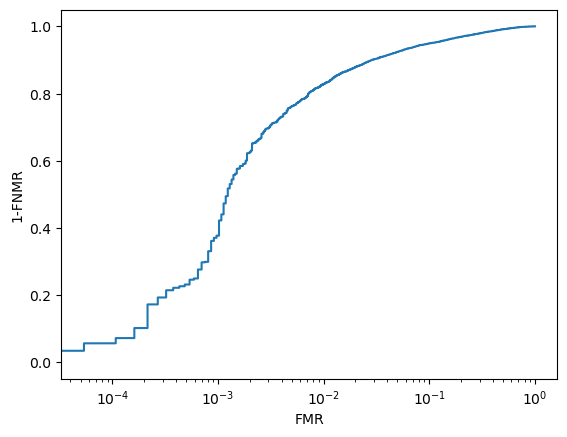

In [8]:
#dimenion 32
gen_pairs = createGenuineIDs(test_identities)
imp_pairs =  createImposterIDs(test_identities)
genuine_scores = computeScores(gen_pairs, reduced_embeddings, cos_sim)
imposter_scores = computeScores(imp_pairs, reduced_embeddings, cos_sim)

gen_id = np.ones(len(genuine_scores))
imp_id = np.zeros(len(imposter_scores))
# merged      
scores = np.hstack([genuine_scores, imposter_scores])
labels = np.hstack([gen_id, imp_id])

fpr, tpr, thresholds = roc_curve(labels, scores)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FMR")
plt.ylabel("1-FNMR")
plt.xscale("log")

plt.show()

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model for learning compact embeddings and identity classification
def create_combined_model(embedding_dim, num_classes):
    # Input layer for the 128-dimensional embeddings
    input_layer = keras.Input(shape=(embedding_dim,), name="input_layer")

    # Add multiple hidden layers for feature extraction
    hidden_layer1 = layers.Dense(256, activation="relu", kernel_initializer='normal')(input_layer)
    hidden_layer2 = layers.Dense(128, activation="relu", kernel_initializer='normal')(hidden_layer1)
    hidden_layer3 = layers.Dense(64, activation="relu", kernel_initializer='normal')(hidden_layer2)
    hidden_layer4 = layers.Dense(8, activation="relu", kernel_initializer='normal')(hidden_layer3)

    # Output layer for identity classification
    identity_output = layers.Dense(num_classes, activation="softmax", name="identity_output")(hidden_layer3)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=[hidden_layer4, identity_output], name="combined_model")

    return model

# Specify the dimensions
embedding_dim = 128  # Dimensionality of the input embeddings
num_classes = len(np.unique(train_identities))  # Number of unique identities in your dataset
num_samples = len(x_train)

# Create the combined model
combined_model = create_combined_model(embedding_dim, num_classes)

# Compile the model with appropriate losses and metrics
compact_embedding_loss = "mean_squared_error"  # Loss for learning compact embeddings
identity_classification_loss = "categorical_crossentropy"  # Loss for identity classification

combined_model.compile(
    optimizer="adam",
    loss=[compact_embedding_loss, identity_classification_loss],
    metrics={"identity_output": "accuracy"},
)

# Summary of the model architecture
combined_model.summary()

# Training
# Replace x_train and train_identities with your own data
# y_train_identity should be one-hot encoded
x_train = np.random.rand(num_samples, embedding_dim)  # Replace with actual data
train_identities = np.random.randint(0, num_classes, size=num_samples)  # Replace with actual identity labels

# One-hot encode identity labels
y_train_identity = keras.utils.to_categorical(train_identities, num_classes=num_classes)

history = combined_model.fit(
    x_train,
    {"identity_output": y_train_identity},
    epochs=50,
    batch_size=32,
    verbose=2,
)

# After training, get the compact embeddings and identity predictions
[compact_embeddings, identity_predictions] = combined_model.predict(x_test)

def threshold_small_values(embeddings, threshold, min_value):
    """
    Threshold small values in the embeddings and set them to a minimum value.

    Args:
        embeddings: Numpy array containing the embeddings to be thresholded.
        threshold: Values smaller than this threshold will be replaced.
        min_value: Values smaller than the threshold will be replaced with this minimum value.
    """
    small_values = embeddings < threshold
    embeddings[small_values] = min_value

# Post-process compact_embeddings to set small values to a minimum value
threshold_small_values(compact_embeddings, threshold=1e-6, min_value=1e-6)

# compact_embeddings now has small values set to the minimum value


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          33024       ['input_layer[0][0]']            
                                                                                                  
 dense_4 (Dense)                (None, 128)          32896       ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 64)           8256        ['dense_4[0][0]']                
                                                                                     

Epoch 37/50
247/247 - 0s - loss: 5.3089 - dense_6_loss: 0.0000e+00 - identity_output_loss: 5.3089 - identity_output_accuracy: 0.0306 - 220ms/epoch - 889us/step
Epoch 38/50
247/247 - 0s - loss: 5.2896 - dense_6_loss: 0.0000e+00 - identity_output_loss: 5.2896 - identity_output_accuracy: 0.0313 - 234ms/epoch - 948us/step
Epoch 39/50
247/247 - 0s - loss: 5.2652 - dense_6_loss: 0.0000e+00 - identity_output_loss: 5.2652 - identity_output_accuracy: 0.0341 - 225ms/epoch - 910us/step
Epoch 40/50
247/247 - 0s - loss: 5.2394 - dense_6_loss: 0.0000e+00 - identity_output_loss: 5.2394 - identity_output_accuracy: 0.0356 - 230ms/epoch - 932us/step
Epoch 41/50
247/247 - 0s - loss: 5.2110 - dense_6_loss: 0.0000e+00 - identity_output_loss: 5.2110 - identity_output_accuracy: 0.0347 - 230ms/epoch - 930us/step
Epoch 42/50
247/247 - 0s - loss: 5.1790 - dense_6_loss: 0.0000e+00 - identity_output_loss: 5.1790 - identity_output_accuracy: 0.0386 - 240ms/epoch - 973us/step
Epoch 43/50
247/247 - 0s - loss: 5.1635 

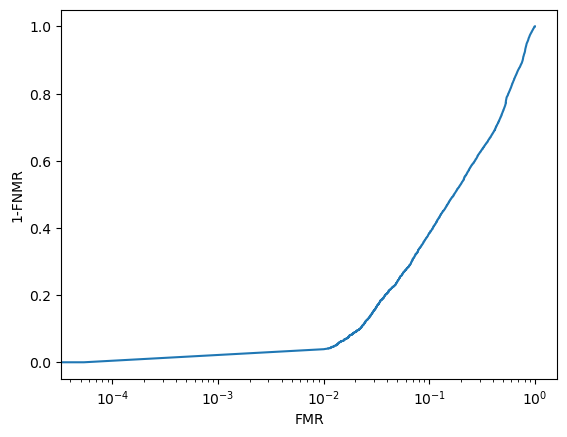

In [10]:
#dimension 32
gen_pairs = createGenuineIDs(test_identities)
imp_pairs =  createImposterIDs(test_identities)
genuine_scores = computeScores(createGenuineIDs(test_identities), compact_embeddings, cos_sim)
imposter_scores = computeScores(createImposterIDs(test_identities), compact_embeddings, cos_sim)

gen_id = np.ones(len(genuine_scores))
imp_id = np.zeros(len(imposter_scores))
# merged      
scores = np.hstack([genuine_scores, imposter_scores])
labels = np.hstack([gen_id, imp_id])

fpr, tpr, thresholds = roc_curve(labels, scores)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FMR")
plt.ylabel("1-FNMR")
plt.xscale("log")

plt.show()